In [16]:
# Generate the data
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from pathlib import Path
import matplotlib.pyplot as plt
import pickle
from tqdm.auto import tqdm, trange



def generate_xy_equally_spaced(n=10000):
    random.seed(42) 

    x = np.linspace(0, 1, n)
    random.shuffle(x)  # shuffle the x values to ensure randomness
    # y = np.exp(x)
    y = x**2
    return x, y


In [17]:
# model (TensorFlow 2 / Keras)
def make_model(seed=None):
    if seed is not None:
        tf.random.set_seed(seed)
    

    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(1,)),
        tf.keras.layers.Dense(2, activation='sigmoid'),
        tf.keras.layers.Dense(3, activation='sigmoid'),
        tf.keras.layers.Dense(3, activation='sigmoid'),
        tf.keras.layers.Dense(2, activation='sigmoid'),
        tf.keras.layers.Dense(1, activation='linear')
    ])
    model.compile(optimizer='adam',
                  loss='mse',
                  metrics=["mse"])
    return model


In [18]:
# Training
OUT = Path("nn_distributions"); OUT.mkdir(exist_ok=True)

def train_many(n_runs=1000, n_samples=1000, epochs=100, inverse=False):

    seeds = []
    
    for seed in trange(n_runs, desc="Training runs"):
        
        tf.keras.backend.clear_session()
        x, y = generate_xy_equally_spaced(n_samples)
        if inverse:
            x, y = y, x

        split = int(0.8 * n_samples)
        x_train, x_test = x[:split], x[split:]
        y_train, y_test = y[:split], y[split:]
        
# --- build the model ---
        model = make_model()
        model.fit(x_train, y_train, epochs=epochs, verbose=0)

        # save the trained model
        model.save(OUT / f"model_seed_{seed}.keras")

        seeds.append(seed)

    return seeds


In [19]:
def extract_metrics(seeds, n_samples=1000, inverse=False):
    """
    Given a list of seeds, load each saved model, regenerate test data,
    collect weights, biases, and test errors, and return three DataFrames.
    """
    weight_rows = []
    bias_rows   = []
    error_rows  = []

    for seed in tqdm(seeds, desc="Extracting metrics"):
        # regenerate data & split
        x, y = generate_xy_equally_spaced(n_samples)
        if inverse:
            x, y = y, x
        split = int(0.8 * n_samples)
        x_test, y_test = x[split:], y[split:]

        # load model
        model = tf.keras.models.load_model(OUT / f"model_seed_{seed}.keras", compile=False)
        model.compile(optimizer="adam", loss="mse", metrics=["mae"])

        # collect weights & biases
        w_vec, b_vec = [], []
        for layer in model.layers:
            W, b = layer.get_weights()
            w_vec.extend(W.flatten())
            b_vec.extend(b.flatten())
        weight_rows.append(w_vec)
        bias_rows.append(b_vec)

        # evaluate on test set
        loss, mae = model.evaluate(x_test, y_test, verbose=0)
        error_rows.append([loss, mae])
        
    return (
    pd.DataFrame(weight_rows),
    pd.DataFrame(bias_rows),
    pd.DataFrame(error_rows, columns=["mse", "mae"]),
)

   

In [20]:
# Run experiments
if __name__ == "__main__":
    # Prepare output folder
    OUT = Path("nn_distributions")
    OUT.mkdir(exist_ok=True)

    # Train & save N runs
    seeds = train_many(
        n_runs=1000,       # number of models to train
        n_samples=1000, # size of dataset
        epochs=100,     # training epochs
        inverse=False   # your flag for swapping x/y
    )
    print(f"[✓] Trained and saved {len(seeds)} models with seeds: {seeds}")

    # Load saved models & pull out metrics
    w_fwd, b_fwd, error_fwd = extract_metrics(
        seeds,
        n_samples=1000,
        inverse=False
    )
    print(f"[✓] Extracted weights, biases, and errors for {len(seeds)} runs")

    # Persist your DataFrames just like before
    for name, df in [
        ("weights_fwd", w_fwd),
        ("biases_fwd",  b_fwd),
        ("errors_fwd",  error_fwd),
    ]:
        with open(OUT / f"{name}.pkl", "wb") as f:
            pickle.dump(df, f)
    print("[✓] Pickle files written in", OUT.resolve())

    print(error_fwd.head())


Training runs:   0%|          | 0/1000 [00:00<?, ?it/s]

[✓] Trained and saved 1000 models with seeds: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212

Extracting metrics:   0%|          | 0/1000 [00:00<?, ?it/s]

[✓] Extracted weights, biases, and errors for 1000 runs
[✓] Pickle files written in C:\Users\filig\Downloads\nn_distributions
        mse       mae
0  0.095408  0.264787
1  0.095419  0.264689
2  0.095264  0.264856
3  0.095160  0.264826
4  0.095347  0.264864


In [21]:
# Load the pickle files
OUT = Path("nn_distributions"); OUT.mkdir(exist_ok=True)

weights_df = pickle.load(open(OUT / "weights_fwd.pkl", "rb"))
biases_df  = pickle.load(open(OUT / "biases_fwd.pkl", "rb"))
error_df = pickle.load(open(OUT / "errors_fwd.pkl", "rb"))   # <- this is a Series
error_df.name = "error"

# Rename columns
weights_df.columns = [f"w{i}" for i in range(weights_df.shape[1])]
biases_df.columns  = [f"b{i}" for i in range(biases_df.shape[1])]

# Combine everything horizontally
combined_df = pd.concat([weights_df, 
                         biases_df, 
                         error_df], 
                         axis=1)


# print(combined_df.head()) 
combined_df.head()

,w0,w1,w2,w3,w4,w5,w6,w7,w8,w9,...,b3,b4,b5,b6,b7,b8,b9,b10,mse,mae
0,2.665824,0.922550,-0.540619,1.605947,-1.132858,0.714637,0.015810,-0.827927,0.810845,-0.292946,...,-0.234920,0.120401,0.365803,0.225452,0.232473,-0.241882,0.204072,0.312570,0.095408,0.264787
1,2.669831,0.921327,-0.540861,1.609458,-1.134577,0.715063,0.012271,-0.824667,0.808700,-0.294904,...,-0.240939,0.123916,0.365070,0.224132,0.232272,-0.241669,0.203292,0.312312,0.095419,0.264689
2,2.671144,0.925560,-0.541598,1.609105,-1.135426,0.714189,0.016720,-0.828159,0.811918,-0.292879,...,-0.236108,0.121556,0.367177,0.225816,0.232843,-0.242329,0.205325,0.313279,0.095264,0.264856
3,2.678157,0.926412,-0.543600,1.615436,-1.139359,0.713155,0.013854,-0.826291,0.808640,-0.294692,...,-0.242059,0.125044,0.366955,0.224970,0.232948,-0.242479,0.205373,0.313598,0.095160,0.264826
4,2.666189,0.923064,-0.539302,1.606149,-1.132497,0.714645,0.017999,-0.828927,0.812520,-0.291453,...,-0.234305,0.119150,0.365921,0.226538,0.232801,-0.242212,0.204699,0.313029,0.095347,0.264864


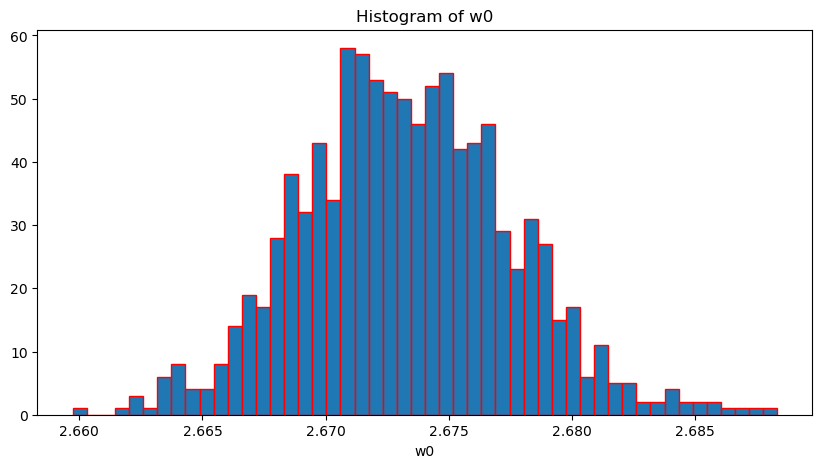

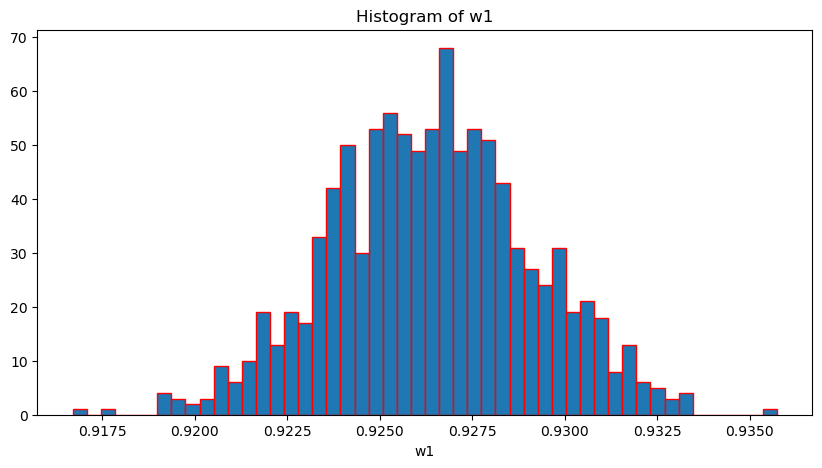

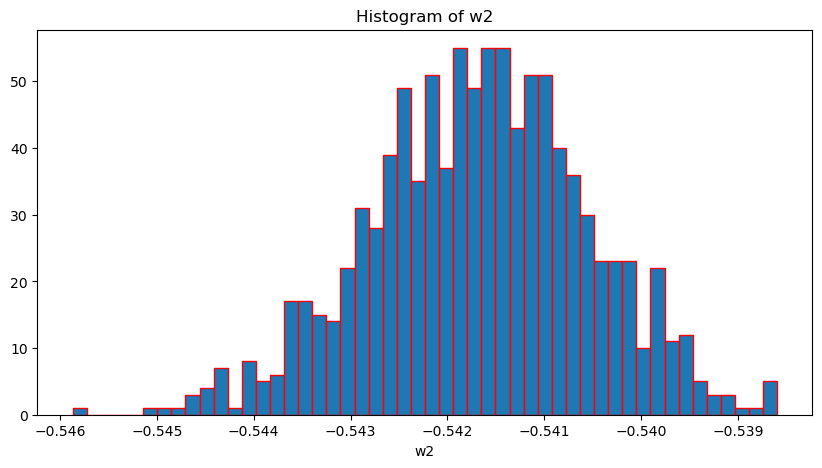

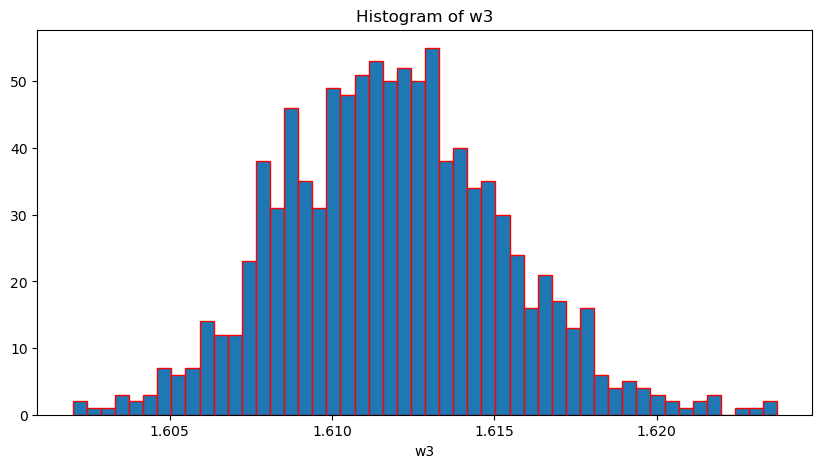

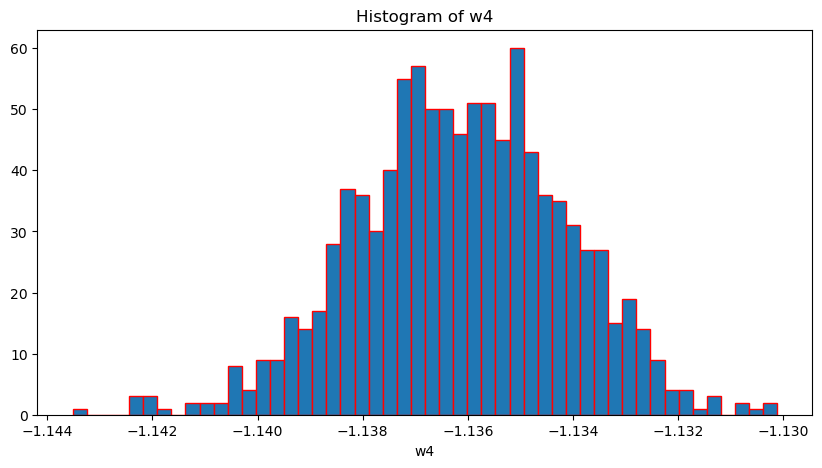

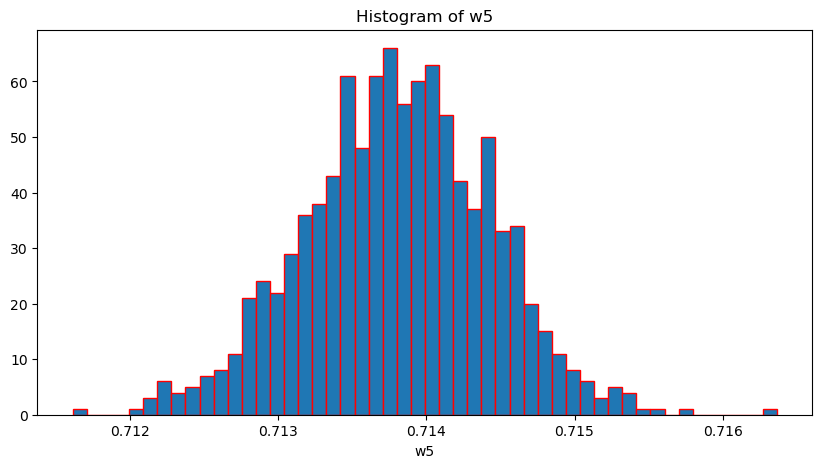

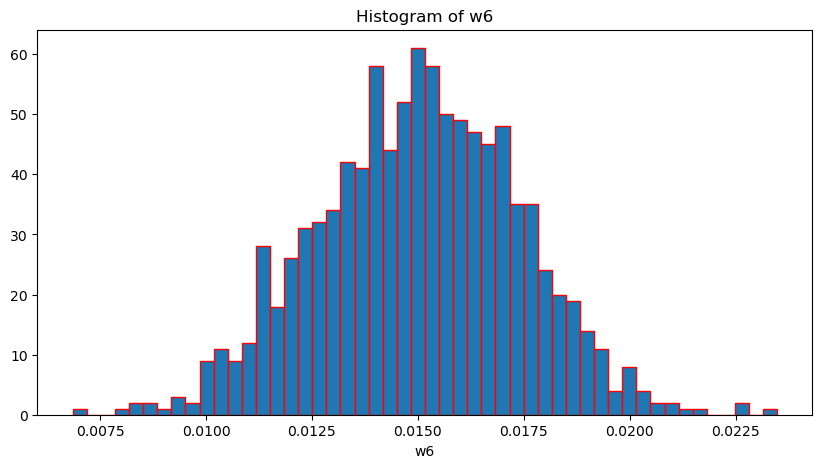

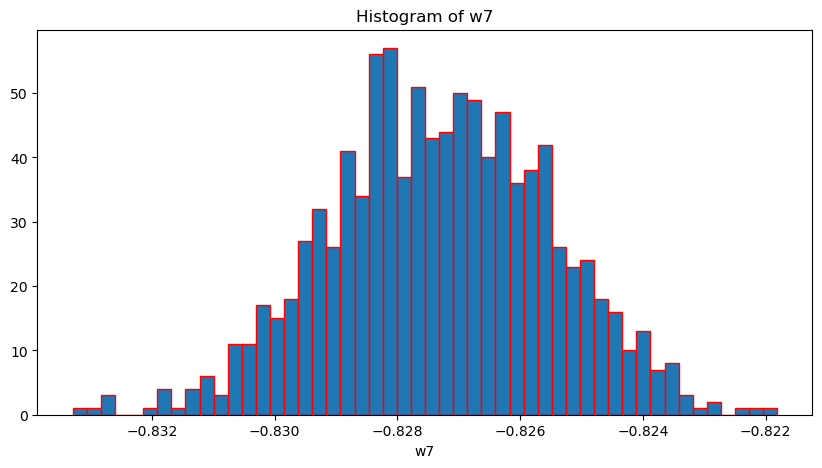

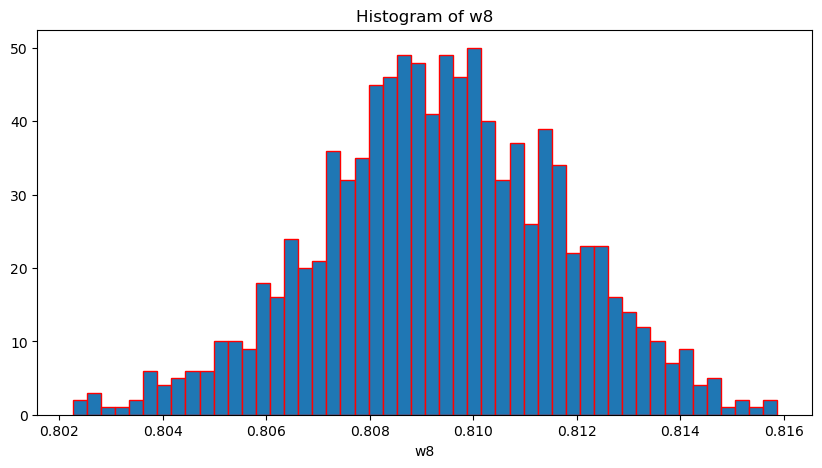

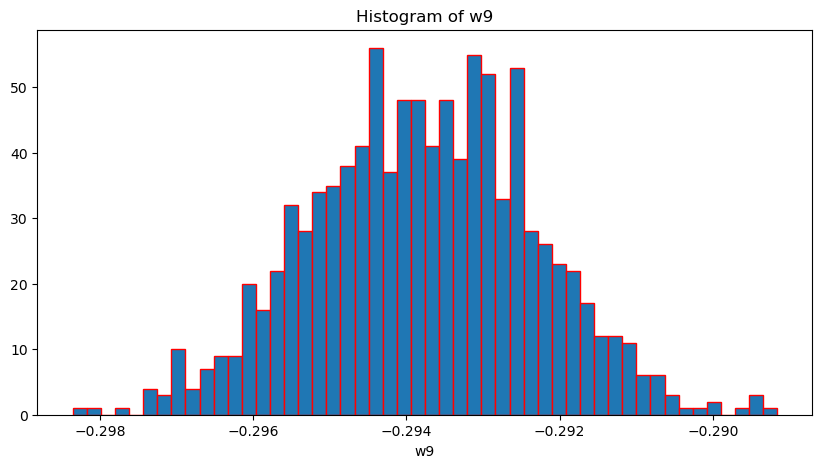

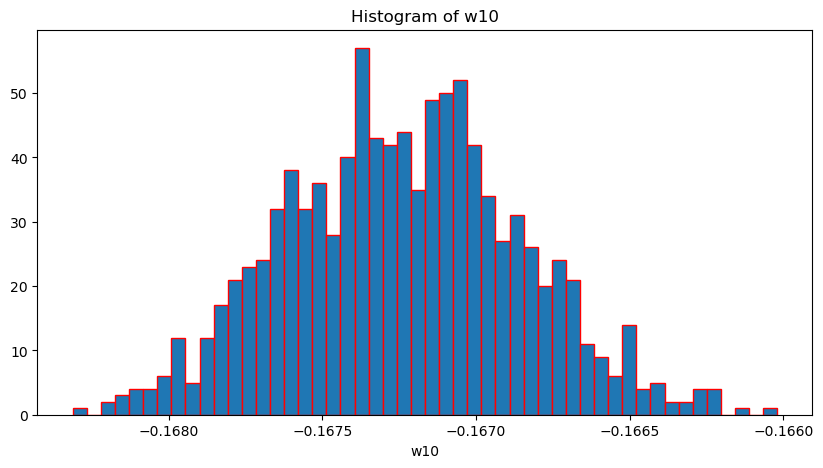

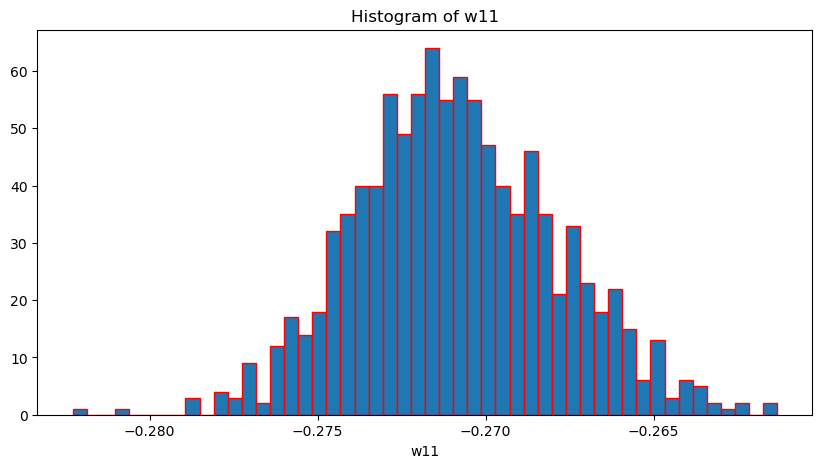

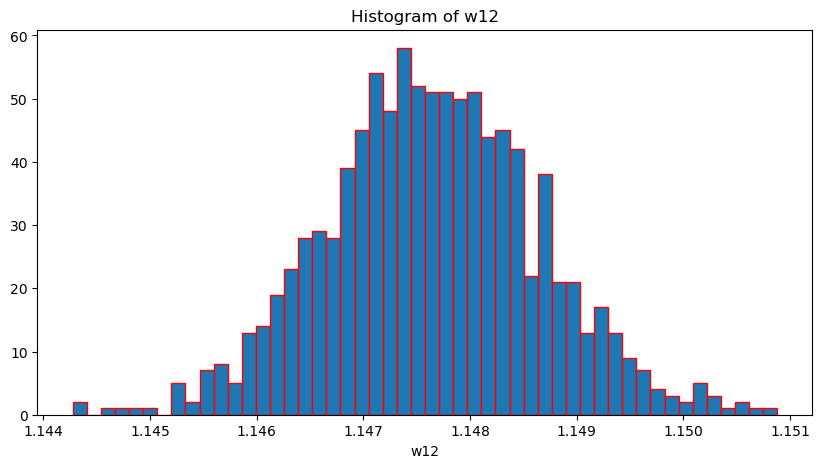

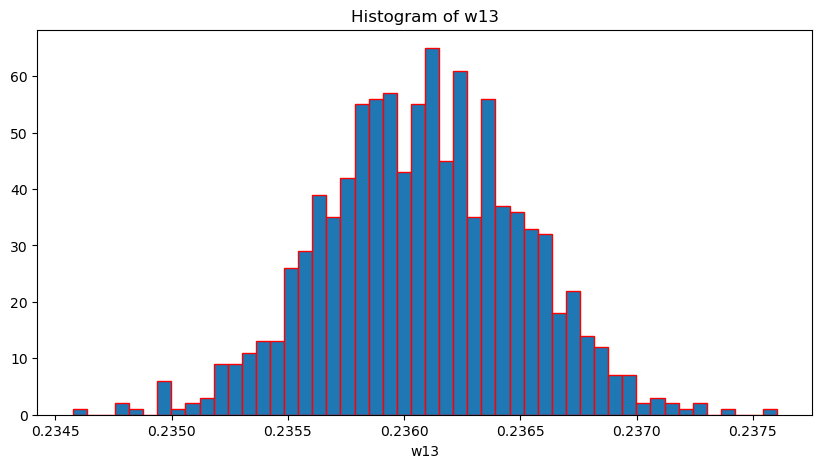

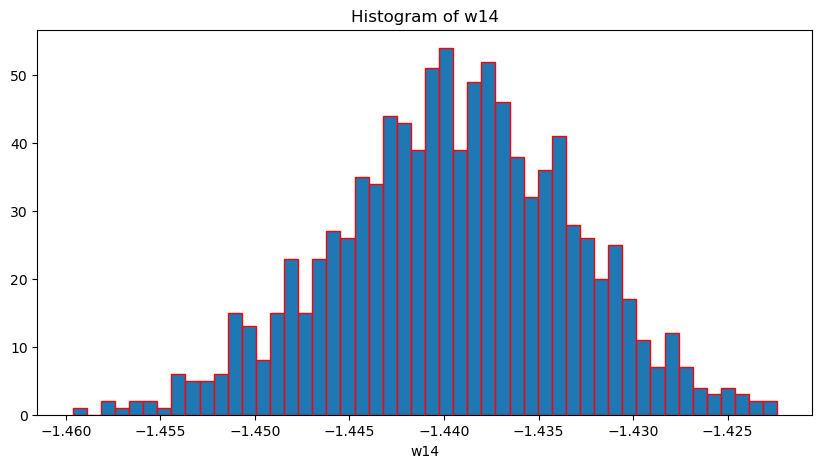

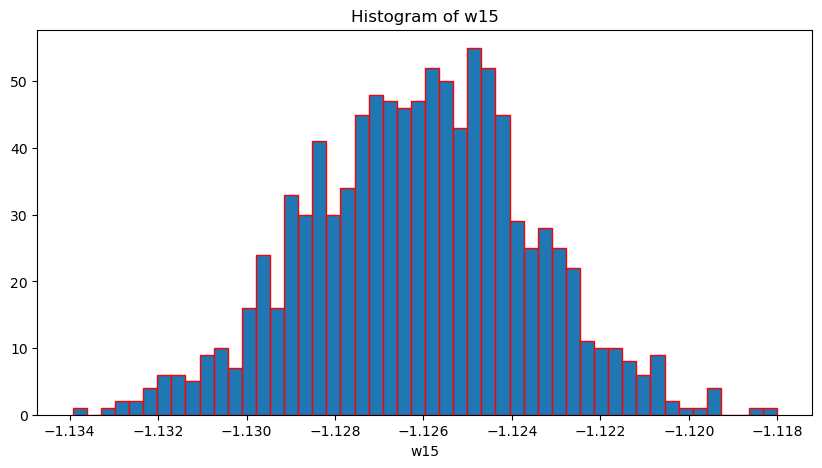

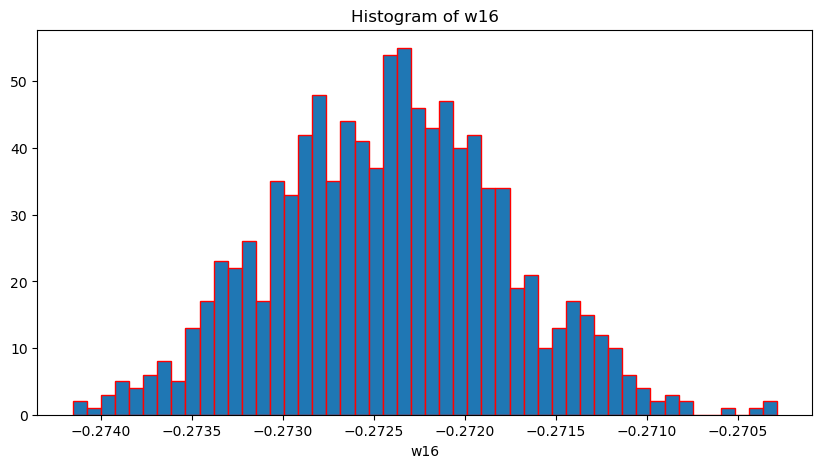

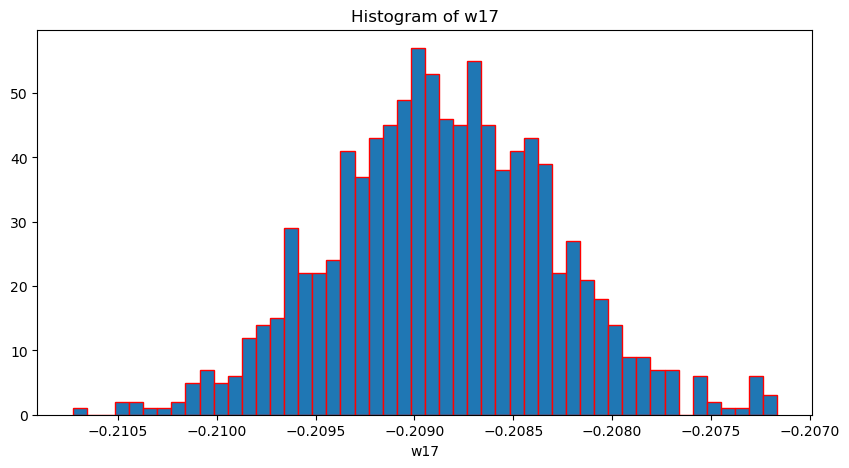

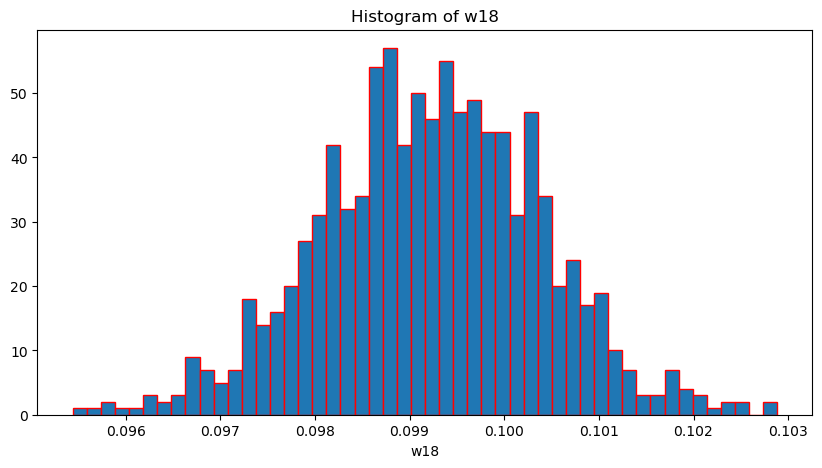

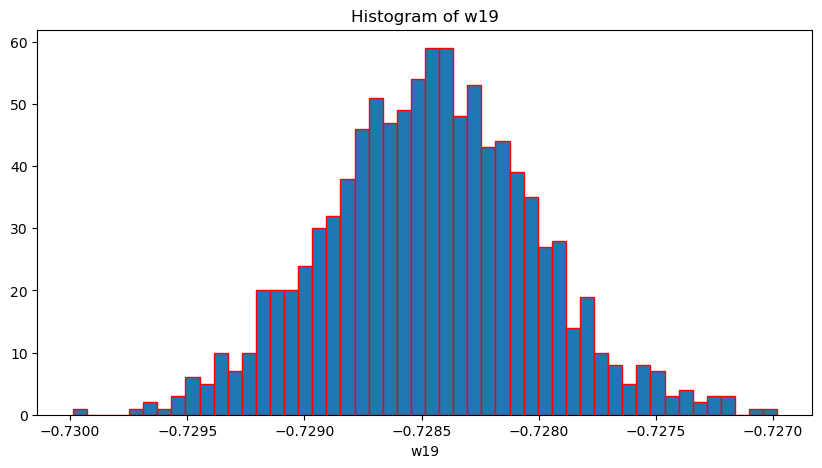

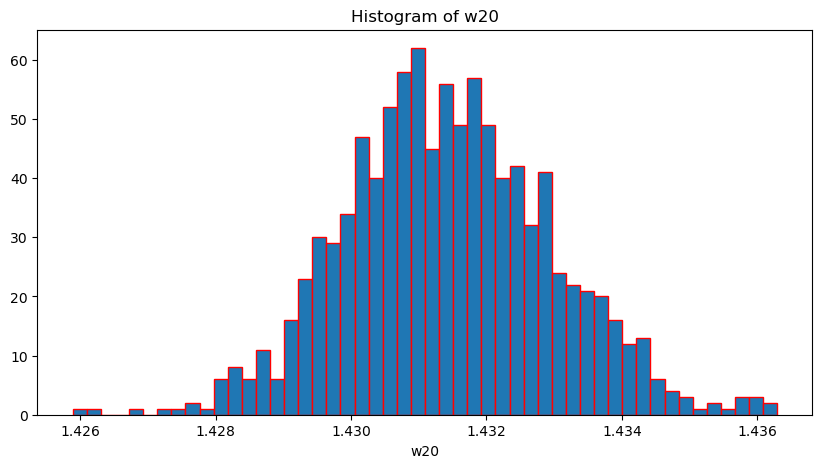

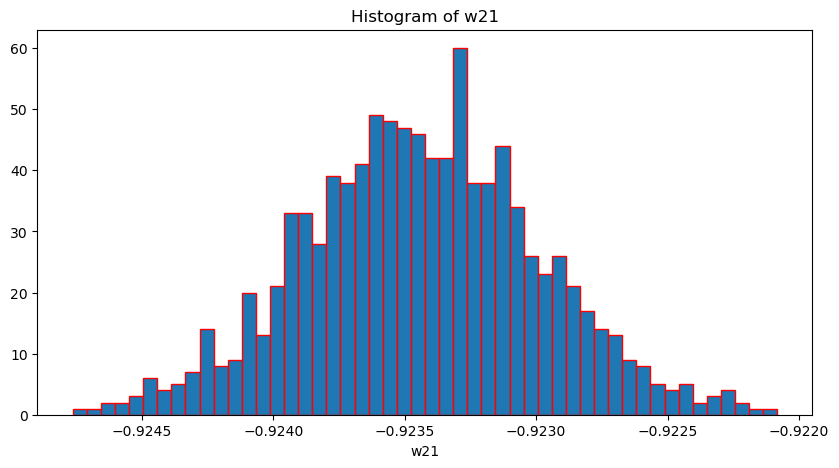

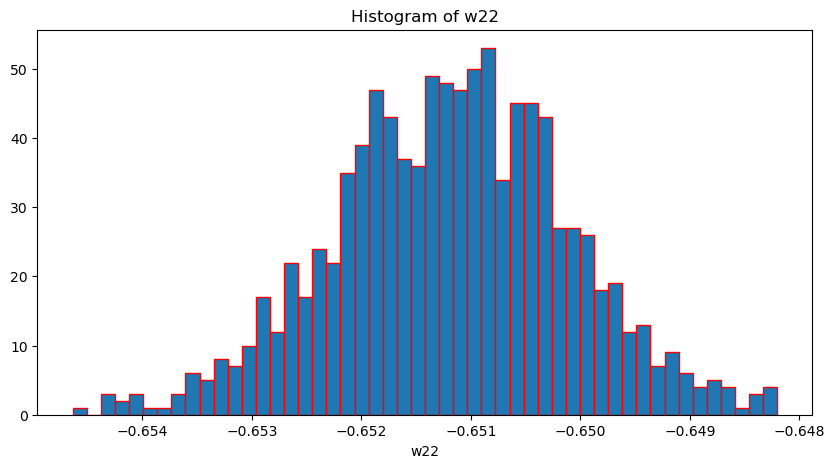

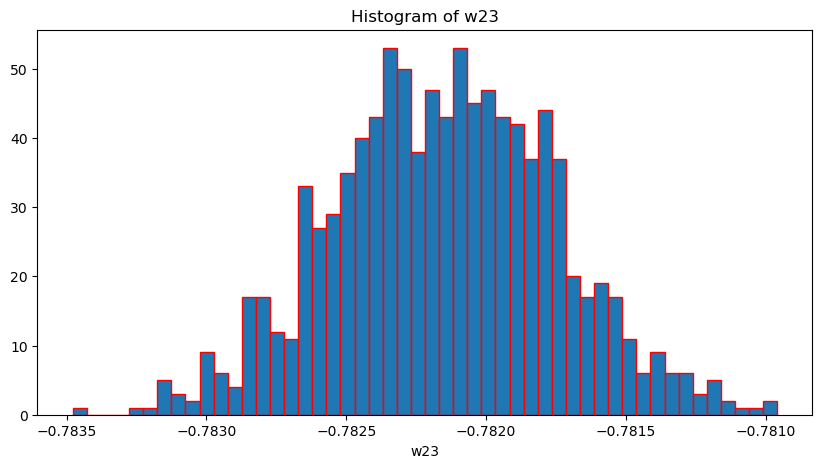

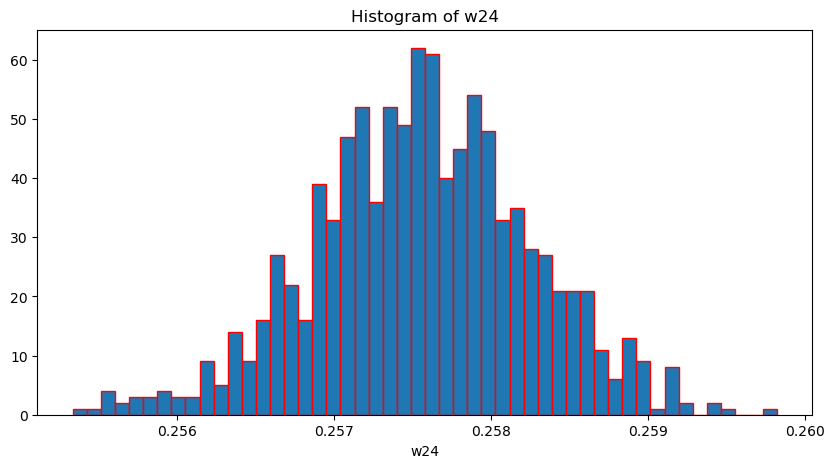

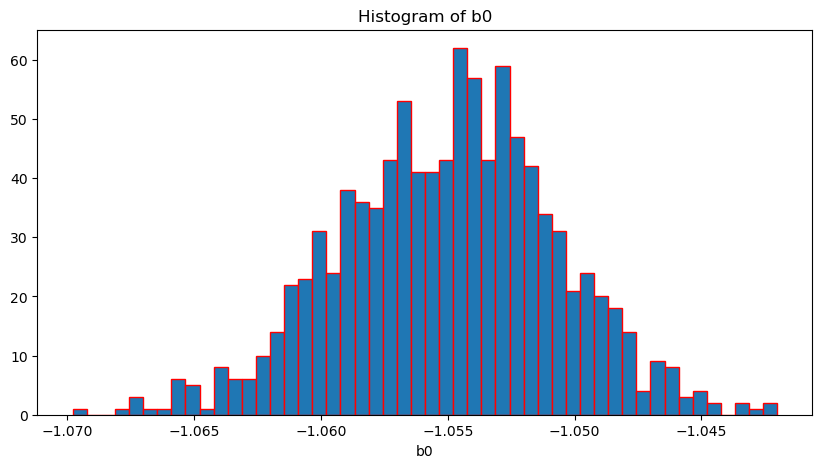

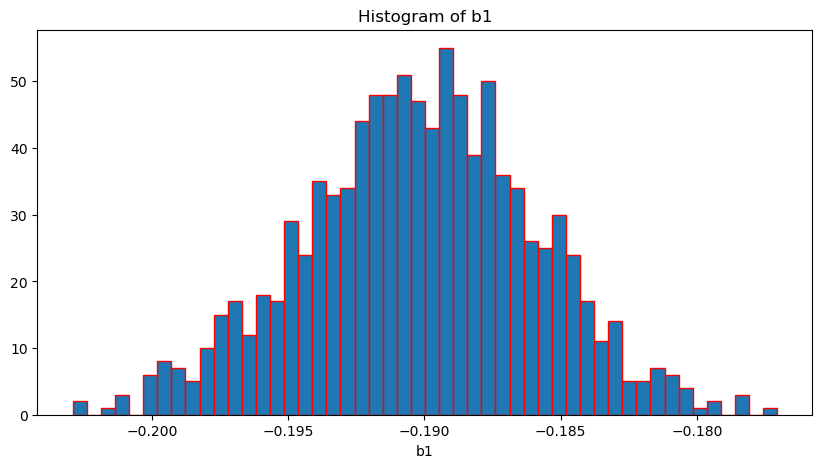

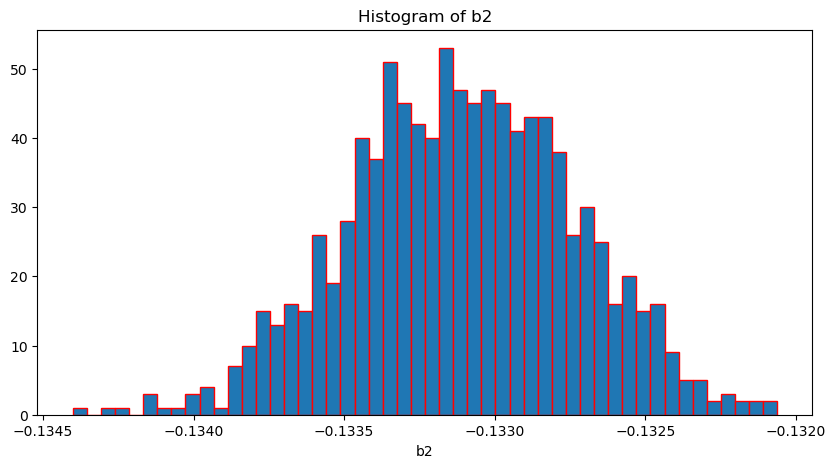

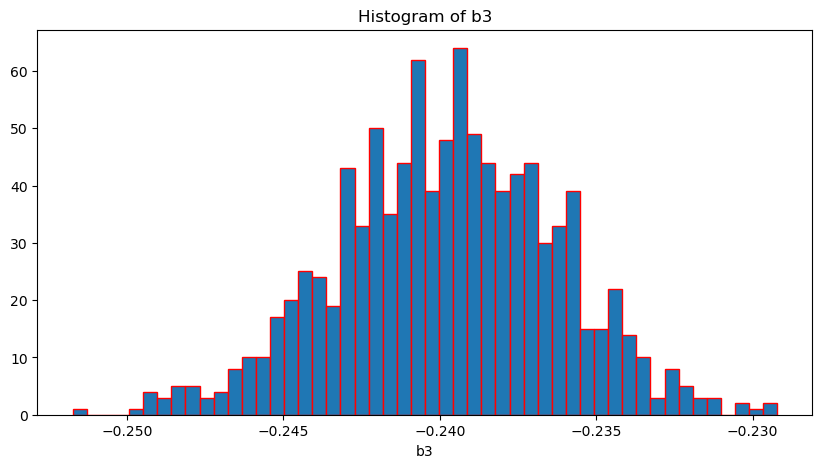

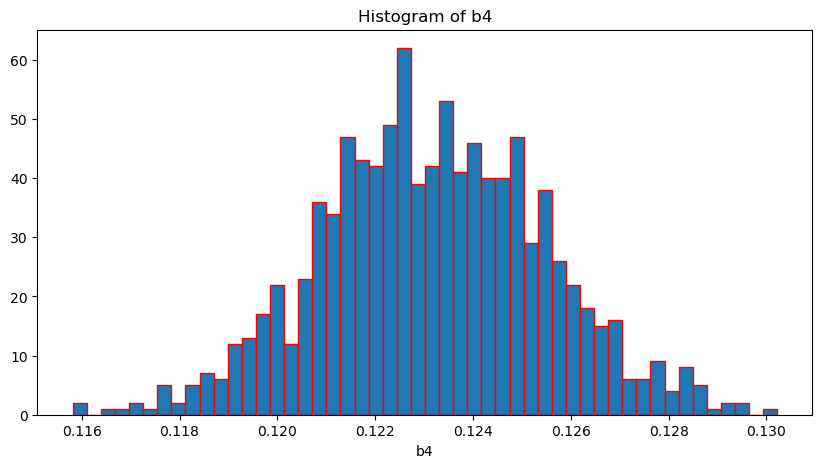

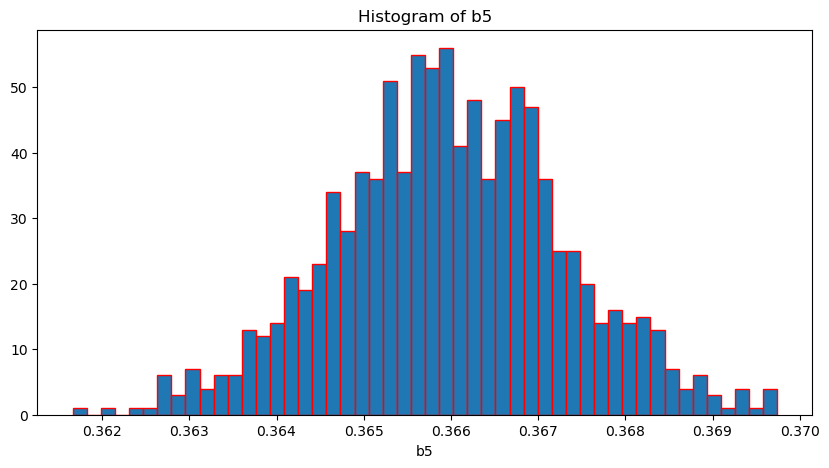

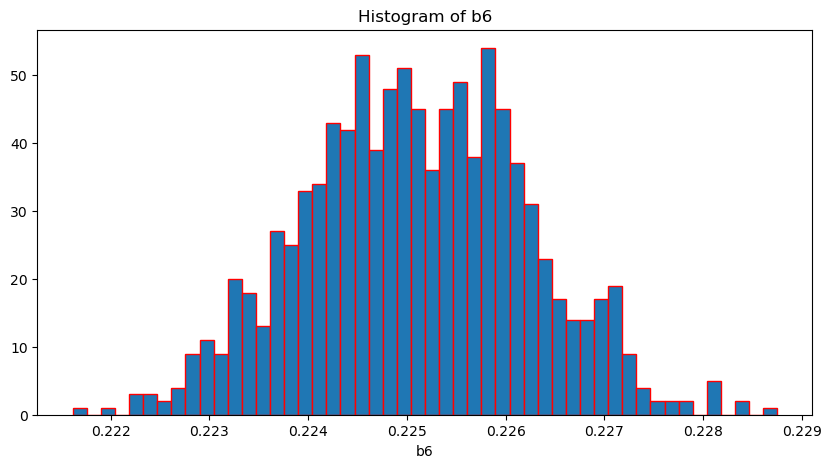

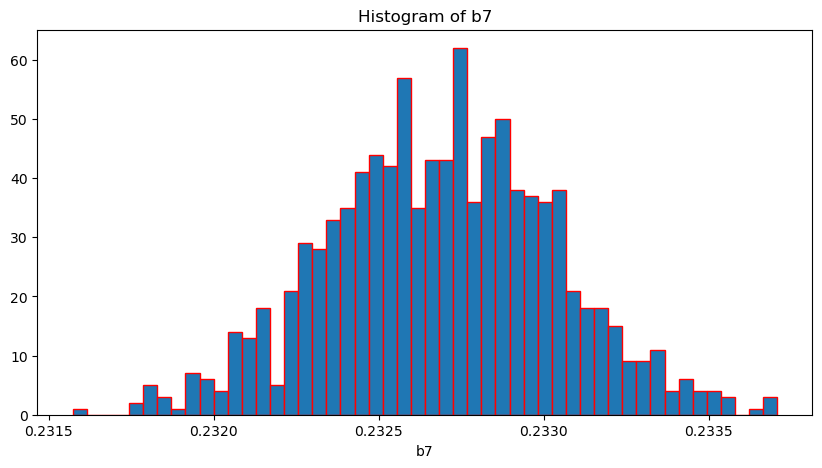

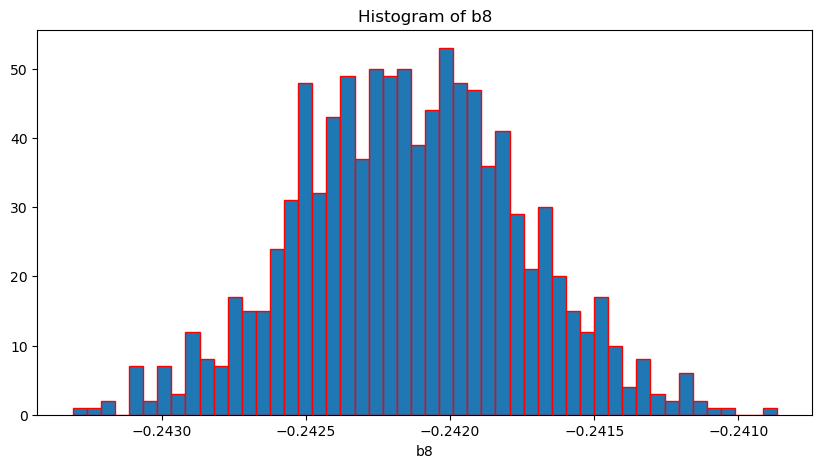

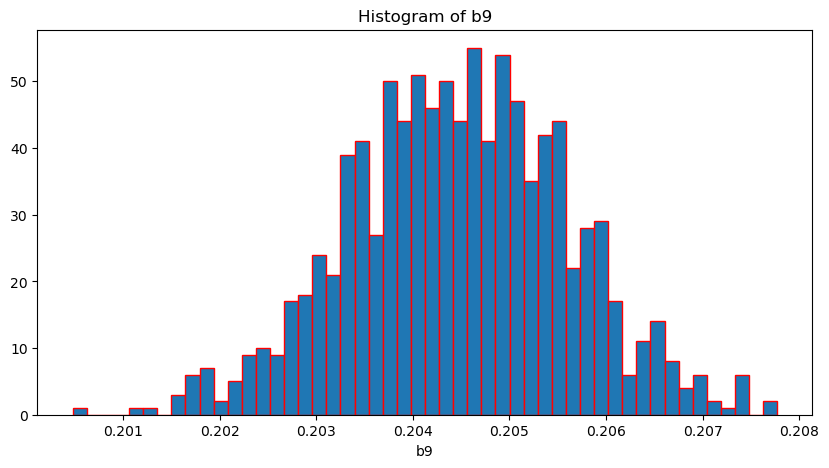

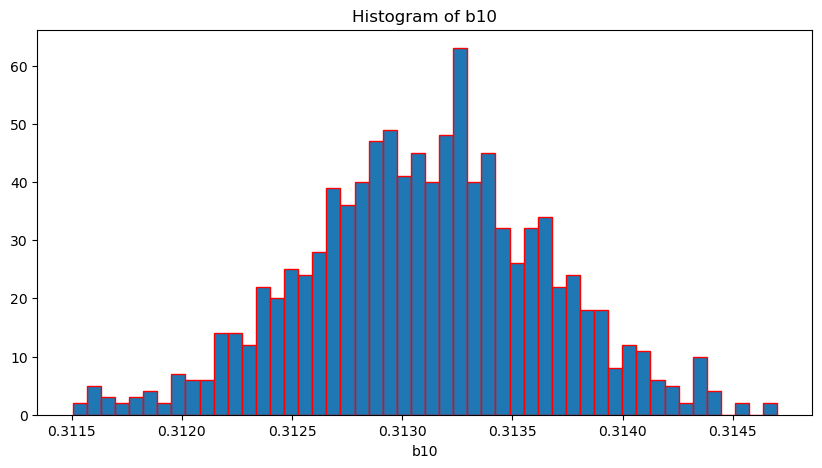

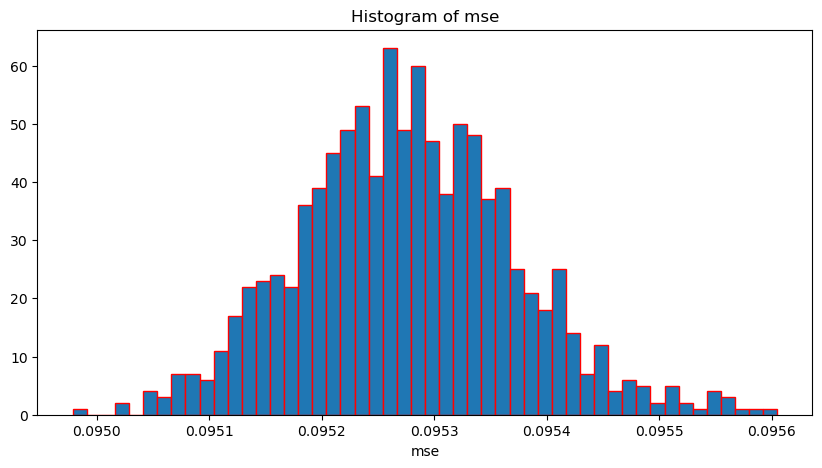

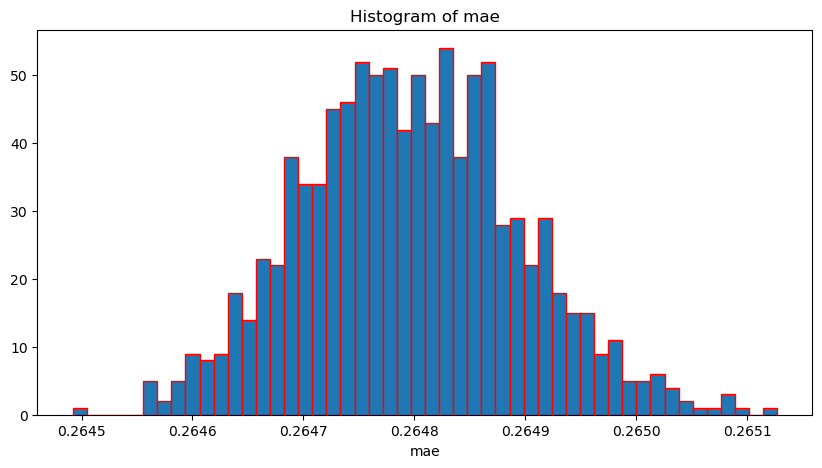

In [22]:
#weights_df['w1'].plot.hist(bins=50, title='w0', edgecolor='red')
col_name = combined_df.columns
for col in col_name:
    x = combined_df[col]
    plt.figure(figsize=(10, 5))
    plt.title(f"Histogram of {col}")
    plt.xlabel(col)
    plt.hist(x,bins=50, edgecolor='red')
    plt.title(f"Histogram of {col}")
    plt.show()


In [ ]:
biases_df['b0'].plot.hist(bins=50, title='b0', edgecolor='red')

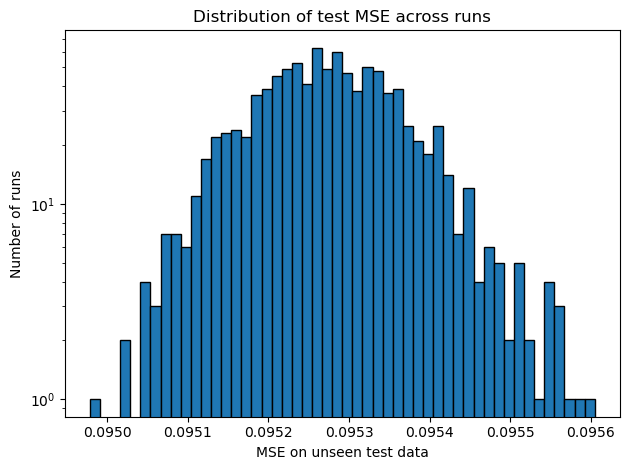

In [23]:
# Load your pickled DataFrame
OUT = Path("nn_distributions")
err_df = pickle.load(open(OUT / "errors_fwd.pkl", "rb"))

# Extract the MSE column as a numpy array, it handles both DataFrame and Series cases
if hasattr(err_df, "columns"):
    # DataFrame: grab the 'mse' column
    mse = err_df["mse"].astype(float).values
else:
    # Series: just use its values
    mse = err_df.astype(float).values

# Plot
plt.figure()
counts, bins, patches = plt.hist(
    mse,
    bins=50,
    edgecolor='black',
    density=False
)
plt.yscale("log")
plt.xlabel("MSE on unseen test data")
plt.ylabel("Number of runs")
plt.title("Distribution of test MSE across runs")
plt.tight_layout()
plt.show()


In [13]:
import seaborn as sns

# Load the test-losses (MSE)
err_path = OUT / "errors_fwd.pkl"
err_object = pickle.load(open(err_path, "rb"))

mse = pd.Series(err_object).apply(
    lambda v: float(np.squeeze(v))     # flatten & cast
).to_numpy()                           # → simple NumPy array

print("Test-set MSE across runs:")
print(pd.Series(mse).describe().to_string(float_format="%.6g"))


plt.figure()
plt.hist(
    mse,
    bins=50,
    edgecolor='black'
)
plt.yscale("log")
plt.xlabel("MSE on unseen test data")
plt.ylabel("Number of runs")
plt.title("Distribution of test MSE across 10 runs")   # adjust “10” if you run more
plt.tight_layout()
plt.show()

# save the figure alongside your pickles
# plt.savefig(OUT / "mse_histogram.png", dpi=300)
sns.kdeplot(mse, bw_adjust=0.5)


ValueError: Data must be 1-dimensional, got ndarray of shape (3, 2) instead

Found 1000 models, e.g.: [WindowsPath('nn_distributions/model_seed_0.keras'), WindowsPath('nn_distributions/model_seed_1.keras'), WindowsPath('nn_distributions/model_seed_10.keras')]


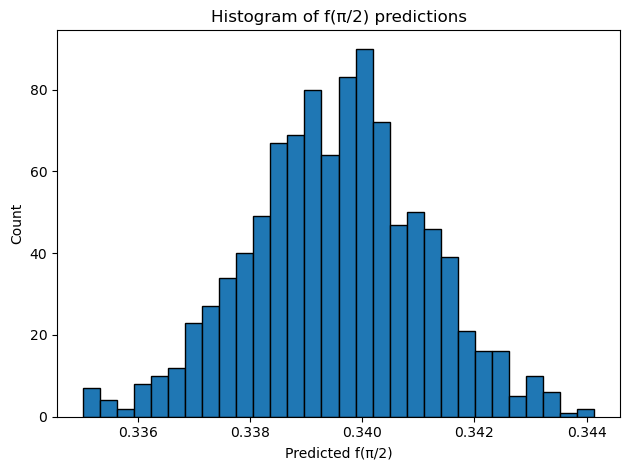

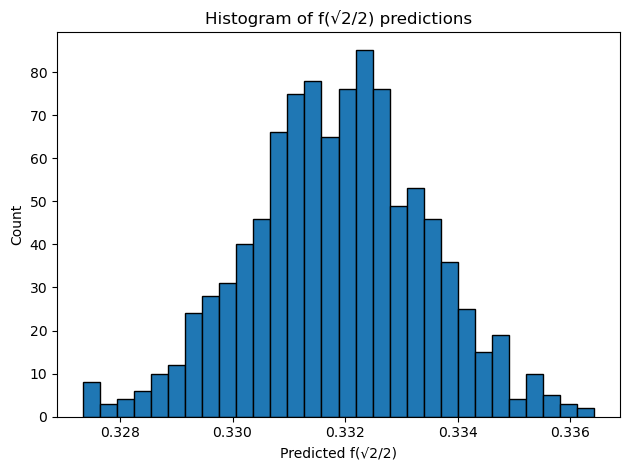

In [24]:
from tensorflow.keras.models import load_model

# Where your models live:
model_dir = Path("nn_distributions")

# Grab only the native-Keras files
model_paths = sorted(model_dir.glob("model_seed_*.keras"))
if not model_paths:
    raise FileNotFoundError(f"No model_seed_*.keras files found in {model_dir}")

print(f"Found {len(model_paths)} models, e.g.: {model_paths[:3]}")

# The two input points: π/2 and √2/2
x_new = np.array([[np.pi/2],
                  [np.sqrt(2)/2]], dtype=float)

# Loop & collect predictions
all_preds = []
for mp in model_paths:
    model = load_model(mp, compile=False)
    preds = model.predict(x_new, verbose=0).flatten()
    all_preds.append(preds)

# Stack into shape (n_models, 2)
all_preds = np.vstack(all_preds)

# Split out each set of predictions
pred_pi   = all_preds[:, 0]
pred_s2o2 = all_preds[:, 1]

# Plot histograms
plt.figure()
plt.hist(pred_pi, bins=30, edgecolor="black")
plt.title("Histogram of f(π/2) predictions")
plt.xlabel("Predicted f(π/2)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

plt.figure()
plt.hist(pred_s2o2, bins=30, edgecolor="black")
plt.title("Histogram of f(√2/2) predictions")
plt.xlabel("Predicted f(√2/2)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Headinig

>this is my code


$RMSE = \sum (y-\hat{y})^2$